In [1]:
from __future__ import division

import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import bz2

In [3]:
# local libs
import config, models, setup
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [28]:
n = 500*1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data

Encoding midi-data
 500
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [31]:
[(k,v) for k,v in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/05 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/03 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/04 8th Perc.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/06 8th Perc.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/02 8th Hat.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/07 8th Perc.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/06 Moonglow 140BPM/01 8th Hat.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/05 Straight Line 136BPM/06 8th hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/05 Straight Line 136BPM/02 8th Ride.mid"),
 (9,
  "../datasets/dr

m (50, 7, 1)


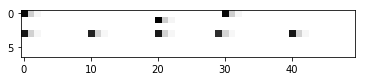

m (50, 7, 1)


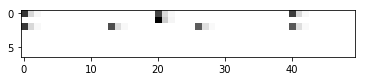

In [40]:
i,j = 0, 322
m = 50
plot.single(x_train[0,:m])
plot.single(x_train[323,:m])

In [32]:
x_train.shape

(500, 160, 7, 1)

In [70]:
a = midi.concatenate(x_train[i:i+2])
b = midi.concatenate(x_train[j:j+2])
ab = midi.concatenate(x_train[[i,j]])
# ab = midi.concatenate([a,b])

In [71]:
d = {'a1':x_train[i], 'b1':x_train[j], 'a':a, 'b':b, 'ab':ab}
midis = {k:midi.decode.track(context,v) for k,v in d.items()}

 [INFO] : 
 |  len, max_t
 |  3.780208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.855208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  7.7802083333333325
 |  4.0
 [INFO] : 
 |  len, max_t
 |  7.855208333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  7.855208333333333
 |  4.0


In [72]:
os.getcwd()

'/Users/mark/src/pattern-recognition/src'

In [73]:
mido.MidiFile(config.tmp_dir + 'abc.mid')

<midi file '../tmp/abc.mid' type 1, 1 tracks, 141 messages>

In [74]:
# io.reset_tmp_dir()
# fn = config.tmp_dir + 'abc.mid'
# print(os.listdir(config.tmp_dir), fn)
# for mid in midis[:]:
#     io.export_midifile(mid, fn)
# #     fn = config.tmp_dir + 'a.txt'
#     with open(fn, encoding='latin-1') as mid_:
#         content = mid_.read().encode('utf-8')
#         compressed = bz2.compress(content)
#         print(type(compressed), len(compressed))

In [76]:
io.reset_tmp_dir()
fn = config.tmp_dir + 'abc.mid'
results = {}
for k, mid in midis.items():
    io.export_midifile(mid, fn)
    mid_ = io.import_midifile(fn, convert=False)
    compressed = bz2.compress(mid_)
    results[k] = len(compressed)
    print('%s: %i' % (k, len(compressed)))

a1: 136
b1: 129
a: 152
b: 153
ab: 184


In [87]:
def compare_results(k1, k2, d: {}):
    v1, v2 = d[k1], d[k2]
    print('%s -> %s: \t%i -> %i, \t%f' % (k1, k2, v1, v2, v1/v2))
    
compare_results('a1', 'a', results)
compare_results('a1', 'ab', results)
compare_results('b1', 'b', results)
compare_results('b1', 'ab', results)

a1 -> a: 	136 -> 152, 	0.894737
a1 -> ab: 	136 -> 184, 	0.739130
b1 -> b: 	129 -> 153, 	0.843137
b1 -> ab: 	129 -> 184, 	0.701087
